In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy import ndarray
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import pickle
from collections import defaultdict

from models.encodings import *
from models.controlled_rotations import *
from models.cnot_models import *
from models.serial_models import *
from  models.model_builder import *

In [3]:
n_qubits = 10
axes = {
        "X": (qml.RX, qml.CRX, qml.IsingXX),
        "Y": (qml.RY, qml.CRY, qml.IsingYY),
        "Z": (qml.RZ, qml.CRZ, qml.IsingZZ)
    }
entangling_strength = ["basic"]
ising_models = []
sequences = []
for axis, (_, _, ising_rot) in axes.items():
    # neighbors can't use the same axis as the middle controlled axis
    neighbors = [axes[a][0] for a in axes if a != axis]  # e.g. [RY, RZ] if m='X'
    for first_rot in neighbors:
        for third_rot in neighbors:
            if first_rot == third_rot:
                sequences.append((first_rot, ising_rot))
            else:
                sequences.append((first_rot, ising_rot, third_rot))

for entangling in entangling_strength:
    for sequence in sequences:
        if entangling == "all_to_all_down":
            measure_wire = n_qubits-1
            trainable_layers_max = 7 - len(sequence) + 2
        elif entangling == "all_to_all":
            measure_wire = 0
            trainable_layers_max = 4
        else:
            measure_wire = 0
            trainable_layers_max = 17 - 5 * (len(sequence) - 2)

        ising_models += [build_parameterized_entangling_model(entangling_strength=entangling, operations=sequence, n_qubits=n_qubits, trainable_layers=l,
                                                              measure_wire=measure_wire if entangling != "strongly" else l-1, measure_axis=qml.PauliZ,
                                                              encoding=univariate_parallel_encoding, scaling=1, random_key=jax.random.PRNGKey(0)) for l in range(1, 2)]
idx = 0
for i in ising_models:
    print(i[-1], i[-2])
    idx += 1
idx

basic_ry_rxx_ry_measured_at_0_in_z 51
basic_ry_rxx_rz_measured_at_0_in_z 51
basic_rz_rxx_ry_measured_at_0_in_z 51
basic_rz_rxx_rz_measured_at_0_in_z 51
basic_rx_ryy_rx_measured_at_0_in_z 51
basic_rx_ryy_rz_measured_at_0_in_z 51
basic_rz_ryy_rx_measured_at_0_in_z 51
basic_rz_ryy_rz_measured_at_0_in_z 51
basic_rx_rzz_rx_measured_at_0_in_z 51
basic_rx_rzz_ry_measured_at_0_in_z 51
basic_ry_rzz_rx_measured_at_0_in_z 51
basic_ry_rzz_ry_measured_at_0_in_z 51


12

strongly_ry_rz_ry_cnot_measured_at_2_in_z 
 753 
 {'resources': Resources(num_wires=10, num_gates=1003, gate_types=defaultdict(<class 'int'>, {'RY': 502, 'RZ': 251, 'CNOT': 240, 'RX': 10}), gate_sizes=defaultdict(<class 'int'>, {1: 763, 2: 240}), depth=190, shots=Shots(total_shots=None, shot_vector=())), 'errors': {}, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_trainable_params': 0, 'num_device_wires': 10, 'num_tape_wires': 10, 'device_name': 'default.qubit', 'level': 'gradient', 'gradient_options': {}, 'interface': 'jax', 'diff_method': 'best', 'gradient_fn': 'backprop'}


C:\Users\test\AppData\Local\Temp\ipykernel_3512\4284593575.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


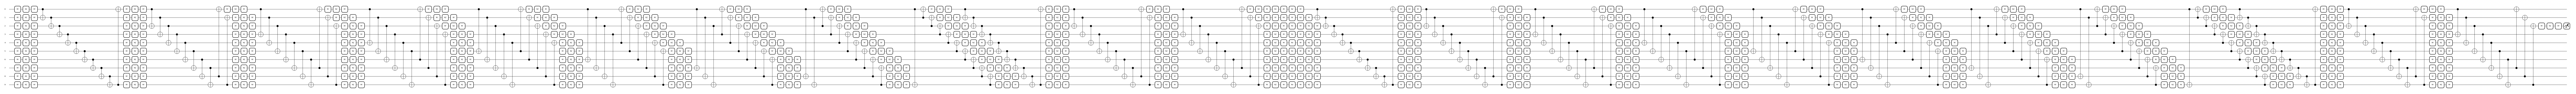

In [9]:
n_qubits = 10
layer = 12
qm, weights, total_size, name = build_nonparameterized_entangling_model("strongly", (qml.RY, qml.RZ, qml.RY, qml.CNOT), n_qubits, layer, (layer-1)%(n_qubits-1), qml.PauliZ, across_qubits_multivariate_parallel_encoding, 3, jax.random.PRNGKey(0), False)
spec = qml.specs(qm)(jnp.zeros((2,1)), weights)
# print(qml.draw(qm, level="device")(jnp.zeros((2,1)), weights))
print(name, "\n", total_size, "\n", spec)
fig, ax = qml.draw_mpl(qm, level="device")(jnp.zeros((2,1)), weights)
fig.show()

In [53]:
op = qml.IsingXY(jnp.zeros((1,)), wires=(0, 1))
for subop in op.decomposition():
    print(subop)

H(0)
CY(wires=[0, 1])
RY(Array([0.], dtype=float32), wires=[0])
RX(Array([-0.], dtype=float32), wires=[1])
CY(wires=[0, 1])
H(0)


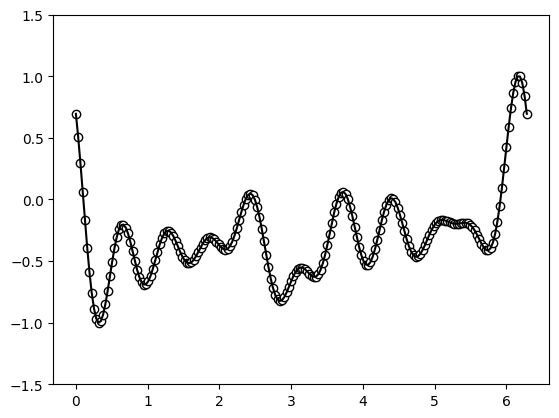

In [54]:
coeffs = [
    (1.29 + 1.13j),  # c_1
    (0.43 + 0.89j),  # c_2
    (1.97 + 1.03j),  # c_3
    (0.17 + 0.59j),  # c_4
    (1.71 + 1.41j),  # c_5
    (0.61 + 0.37j),  # c_6
    (1.19 + 1.67j),  # c_7
    (0.73 + 1.61j),  # c_8
    (0.23 + 0.47j),  # c_9
    (1.83 + 0.83j),  # c_10
]

c0 = 0.0
scaling = 1
key = jax.random.PRNGKey(220)
# coeffs = jax.random.normal(key, (10,)) + 1j * jax.random.normal(jax.random.split(key)[1], (10,))

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

x_raw = jnp.linspace(-12, 12, 200)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)
target_y_scaled = minmax_scaler(target_y) * 2 - 1

plt.plot(x, target_y_scaled, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

In [55]:
def fourier2d(X, Y, C, c0=0.0, scaling=1):
    """
    X, Y : (Nx, Ny) meshgrid
    C    : (Mx, My) complex coefficients for positive modes (m>=1, n>=1)
    """
    Mx, My = C.shape
    m = jnp.arange(1, Mx + 1)  # (Mx,)
    n = jnp.arange(1, My + 1)  # (My,)

    # build phases with broadcasting: (Mx, Ny, Nx) etc. — use tensordot
    # shapes: phaseX -> (Mx, Nx, Ny), phaseY -> (My, Nx, Ny)
    phaseX = jnp.tensordot(m, X, axes=0)
    phaseY = jnp.tensordot(n, Y, axes=0)

    # Combine to (Mx, My, Nx, Ny)
    phase = phaseX[:, None, :, :] + phaseY[None, :, :, :]

    # Sum_{m,n} C[m,n] * exp(i * scaling * phase)
    s = jnp.sum(C[:, :, None, None] * jnp.exp(1j * scaling * phase), axis=(0, 1))
    return c0 + 2.0 * jnp.real(s)

x_raw = jnp.linspace(-12, 12, 200)
y_raw = jnp.linspace(-12, 12, 200)
x = minmax_scaler(x_raw) * 2 * jnp.pi
y = minmax_scaler(y_raw) * 2 * jnp.pi
X, Y = jnp.meshgrid(x, y, indexing="ij")  # (Nx, Ny)

# Option A: full matrix with random 2D coefficients
Mx, My = 10, 10
key = jax.random.PRNGKey(0)
C = (jax.random.cauchy(key, (Mx, My)) + 1j * jax.random.cauchy(jax.random.split(key)[1], (Mx, My)))

# Option B: reuse 1D coeffs by forming a separable outer-product.
# C = (jax.random.normal(key, (100,)) + 1j * jax.random.normal(jax.random.split(key)[1], (100,))).reshape((Mx, My))

c0 = 0.0
scaling = 1
Z = fourier2d(X, Y, C, c0=c0, scaling=scaling)
Z = minmax_scaler(Z) * 2 - 1
Z.shape

(200, 200)

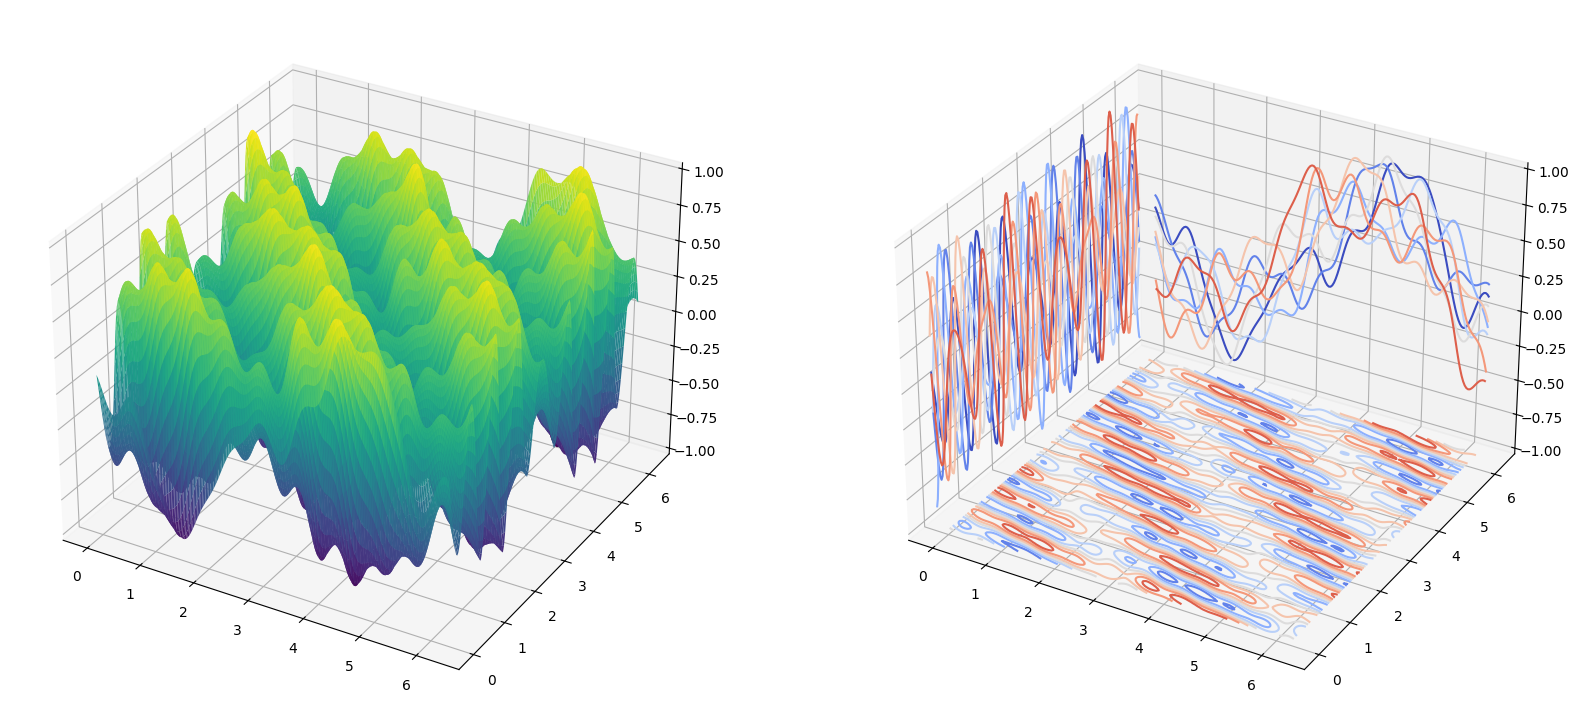

In [58]:

# 3D plot
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection="3d")
# ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z),
#                 rstride=1, cstride=1, linewidth=0, antialiased=True, cmap="viridis")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# plt.tight_layout()
# plt.show()


fig = plt.figure(figsize=(20, 10))

'''First subplot'''
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), rstride=1, cstride=1, linewidth=0, antialiased=True, cmap="viridis")

'''Second subplot'''
ax = fig.add_subplot(122, projection='3d')
# ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), edgecolor='royalblue', lw=0.1, rstride=8, cstride=8, alpha=0.3)

ax.contour(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='z', offset=jnp.min(Z), cmap='coolwarm')
ax.contour(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='x', offset=jnp.min(X)-0.2, cmap='coolwarm')
ax.contour(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='y', offset=jnp.max(Y)+0.2, cmap='coolwarm')

plt.show()


In [ ]:
z_axis = Z[50]
plt.plot(X[:,10], z_axis)
# plt.scatter(X[:,110], z_axis, edgecolors="white", facecolors="black")
plt.show()

In [ ]:
def basic_parallel_2d(encoding, n_qubits, trainable_layers, scaling, key1):
    dev = qml.device("default.qubit", wires=n_qubits)
    num_wx = 2
    n_rot_params = 3
    w_theta_size = trainable_layers * n_qubits * n_rot_params
    train_block_size = w_theta_size + n_qubits * n_rot_params
    total_size = train_block_size + w_theta_size + n_rot_params

    # W_weights = jax.random.uniform(key1, shape=(num_wx, trainable_layers, n_qubits, n_rot_params), minval=0, maxval=2*jnp.pi)
    # final_weights = jax.random.uniform(key2, shape=(num_wx, n_qubits, n_rot_params), minval=0, maxval=2*jnp.pi)
    # weights = {0: W_weights, 1: final_weights}
    weights = jax.random.uniform(key1, shape=(total_size,), minval=0, maxval=2*jnp.pi)

    # encoding with RX-RY on each qubit
    def S(xy):
        x, y = xy
        for w in range(n_qubits):
            qml.RX((scaling**w) * x, wires=w)
            qml.RY((scaling**w) * y, wires=w)

    # encoding x and y each with half of available qubits
    # def S(xy):
    #     x, y = xy
    #     half = n_qubits // 2
    #     for w in range(half):
    #         qml.RX((scaling**w) * x, wires=w)
    #     for w in range(half, n_qubits):
    #         qml.RY((scaling**(w-half)) * y, wires=w)


    def W(theta):
        """train block"""
        for i in range(0, 3*n_qubits, 3):
            qml.Rot(theta[i], theta[i+1], theta[i+2], wires=i//3)
        # Ring entanglement helps couple x/y features -> mixed frequencies m x + n y
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    @qml.qnode(dev, interface="jax")
    def model(xy, weights=weights):
        w1 = weights[:w_theta_size].reshape(trainable_layers, n_qubits*n_rot_params)
        w2 = weights[w_theta_size:train_block_size]
        w3 = weights[train_block_size:-3].reshape(trainable_layers, n_qubits*n_rot_params)

        # W
        for layer in range(trainable_layers):
            W(w1[layer])
        for i in range(0, 3*n_qubits, 3):
            qml.Rot(w2[i], w2[i+1], w2[i+2], wires=i//3)

        # S(x,y)
        # S(xy)
        encoding(xy, n_qubits, scaling)

        # W
        for layer in range(trainable_layers):
            W(w3[layer])
        # last rotation on measure qubit
        qml.Rot(weights[-3], weights[-2], weights[-1], wires=0)

        # S(xy)
        #
        # for layer in range(trainable_layers):
        #     W(weights["W"][2][layer])
        # for i in range(n_qubits):
        #     th = weights["final"][2][i]
        #     qml.Rot(th[0], th[1], th[2], wires=i)


        return qml.expval(qml.PauliZ(0))

    return model, weights, "basic_parallel_2d"


In [ ]:
key1 = jax.random.PRNGKey(0)
model, weights, total_size, name = basic_ry_crx_rz(
    encoding=per_qubit_multivariate_encoding,    # placeholder, not used at creation
    n_qubits=10,
    trainable_layers=3,
    scaling=1,
    random_key=key1
)
# print(qml.draw(model, level="device")(np.array([0.0, 0.0]), weights))
# print(weights.shape)
fig, ax = qml.draw_mpl(model, level="device")(np.array([0.0, 0.0]), weights)
fig.show()

In [ ]:
Nx = 200
Ny = 200
x_raw = jnp.linspace(-12, 12, Nx)
y_raw = jnp.linspace(-12, 12, Ny)
x = minmax_scaler(x_raw) * 2 * jnp.pi
y = minmax_scaler(y_raw) * 2 * jnp.pi

X, Y = jnp.meshgrid(x, y, indexing="ij")             # (Nx, Ny)
XY = jnp.stack([X.ravel(), Y.ravel()], axis=1)       # (Nx*Ny, 2)

# init model
key1 = jax.random.PRNGKey(0)
model, weights, _, _ = all_to_all_cry(
    encoding=per_qubit_multivariate_encoding,
    n_qubits=3,
    trainable_layers=1,
    scaling=3,
    random_key=key1
)

@jax.jit
def predict(XY, weights):
    return jax.jit(jax.vmap(lambda p, w: model(p, w), in_axes=(0, None)), static_argnums=())(XY, weights)

Z_flat = predict(XY, weights)            # (Nx*Ny,)
Z = Z_flat.reshape(Nx, Ny)               # (Nx, Ny)

# print(Z_flat.shape, XY[:,1].shape, Z[:,0].shape, X.shape, Y.shape)
# print(X)

In [ ]:

# plot
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(121, projection="3d")
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True, cmap="viridis", label="hello")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
# # plt.tight_layout()
#
# ax = fig.add_subplot(122, projection='3d')
# # ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
#
# # plot projections of the contours for each dimension
# ax.contour(X, Y, Z, zdir='z', offset=jnp.min(Z), cmap='coolwarm')
# ax.contour(X, Y, Z, zdir='x', offset=-0.2, cmap='coolwarm')
# ax.contour(X, Y, Z, zdir='y', offset=6.2, cmap='coolwarm')
#
# plt.show()

z_axis = Z[:, 0]
xy = []
plt.plot(X[:,10], z_axis)
plt.scatter(X[:,10], z_axis, edgecolors="white", facecolors="black")
plt.show()


In [ ]:
fig = plt.figure(figsize=(20,10))

'''First subplot'''
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z),
                rstride=1, cstride=1, linewidth=0, antialiased=True, cmap="viridis")

'''Second subplot'''
ax = fig.add_subplot(122, projection='3d')
# ax.plot_surface(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)

ax.contourf(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='z', offset=-0.1, cmap='coolwarm')
ax.contourf(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='x', offset=0, cmap='coolwarm')
ax.contourf(jnp.asarray(X), jnp.asarray(Y), jnp.asarray(Z), zdir='y', offset=6, cmap='coolwarm')

plt.show()